In [1]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy import stats
import numpy as np
import xarray as xr
from astropy.time import Time
import metpy.calc as mp
from metpy.units import units
import matplotlib.dates as mdates

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

df1 = readTracks('../data/analysisFiles/TrackRegions1_linear2.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear2.csv')
dfD1T = pd.concat([df1,df4])
dfD1T['SigBS_mean'] = 10**(dfD1T.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear2.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear2.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear2.csv')

def setTrack(df,mooring):
    a = df[['TS_mean','linearSpeed','linearHead','Target_depth_mean']]
    cts,binL = np.histogram(a.linearHead,bins=36,range=[0,360])
    binL = binL[:-1]
    a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
    a['mooring'] = mooring
    return a

def fmtAxis(ax):
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
    ax.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax.xaxis.set_major_formatter(maj_fmt)
    
a = setTrack(dfD1T,1)
b = setTrack(dfD2T,2)
c = setTrack(dfD3T,3)

<ipython-input-1-dcff16948bbd>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
<ipython-input-1-dcff16948bbd>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['mooring'] = mooring


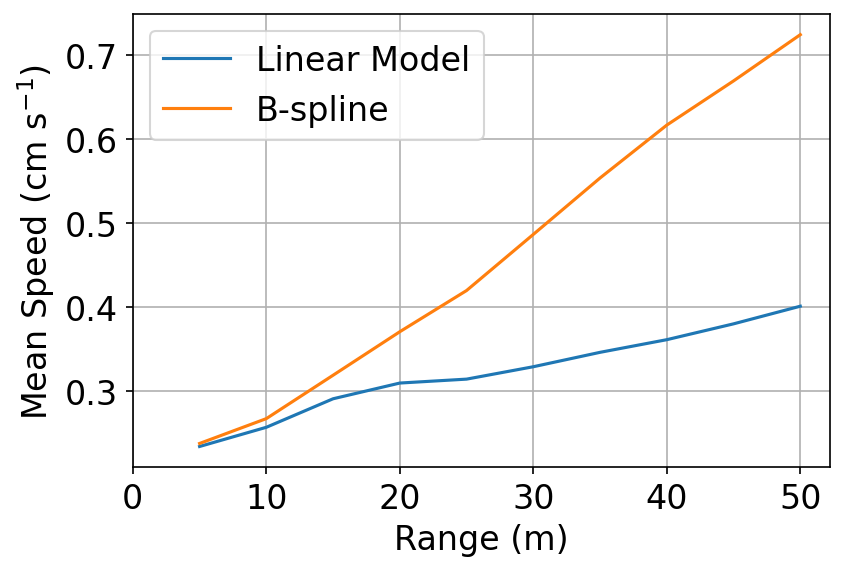

In [91]:
import matplotlib.pyplot as plt
allT = pd.concat([dfD1T,dfD2T,dfD3T])
r = 5

spDir,spLin,spSmooth = [],[],[]
for d in np.arange(0,50,r):
    spDir.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].directSpeed.mean())
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed.mean())
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed.mean())
    
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0,50,r),spLin)
plt.plot(np.arange(0,50,r),spSmooth)
plt.gca().invert_xaxis()
plt.xticks(np.arange(0,51,10))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,-1,-10)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
plt.legend(['Linear Model','B-spline'])
plt.grid()

In [6]:
files = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc',
    '../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc',
    '../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc']
m = [1,1,2,2,3]
dt = []
i = 0
for file in files:
    ds = xr.open_dataset(file,decode_times=False)
    times = ds.time.values+ds.time2.values/1000/60/60/24
    t2 = [Time(time,format='jd').iso for time in times]
    ds['time3'] = pd.to_datetime(t2)
    ds = ds.where(ds.v_1206<1000)
    #dt.append(pd.DataFrame({'dt':ds.time3,'v':np.ravel(ds.sel(depth=28).v_1206),'u':np.ravel(ds.sel(depth=28).u_1205),'mooring':m[i]}))
    dt.append(pd.DataFrame({'dt':ds.time3.values,'u':np.concatenate(np.concatenate(ds.u_1205.mean(dim='depth').values,axis=0)),'v':np.concatenate(np.concatenate(ds.v_1206.mean(dim='depth').values,axis=0)),'mooring':m[i]}))
    i +=1
df = pd.concat(dt)
df = df.set_index('dt')

dt = []
for dfT in [a,b,c]:
    vCur = df[df.mooring==dfT.mooring.unique()[0]]
    vCur = vCur.reindex(dfT.index, method='nearest')
    dfN = pd.merge(dfT,vCur,how='inner', left_index=True, right_index=True)
    dfN['currentDir'] = mp.wind_direction(dfN.u.values*units('cm/s'), dfN.v.values*units('cm/s'),convention='to')
    dfN['currentSpeed'] = mp.wind_speed(dfN.u.values*units('cm/s'), dfN.v.values*units('cm/s'))
    dt.append(dfN.drop_duplicates())
dfMerge = pd.concat(dt)
dfMerge['angOffset'] = abs(dfMerge.currentDir-dfMerge.linearHead)
dfMerge['withCur'] = 0 # set all, this will also be for 'milling'
dfMerge.loc[(dfMerge.angOffset <45) | (dfMerge.angOffset >315), 'withCur'] = 1 # with current
dfMerge.loc[(dfMerge.angOffset >135) & (dfMerge.angOffset <225), 'withCur'] = 2 # against current
dfMerge['tsZone'] = 0 # weak scatterers (lower 25%)
dfMerge.loc[(dfMerge.TS_mean >dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]) & (dfMerge.TS_mean <dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]), 'tsZone'] = 1 # 25- 50%
dfMerge.loc[(dfMerge.TS_mean >dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]) & (dfMerge.TS_mean <dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]), 'tsZone'] = 2 # 50-75%
dfMerge.loc[(dfMerge.TS_mean > dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]), 'tsZone'] = 3 # top 25%
dfMerge['speed'] = 0 # slow
dfMerge.loc[(dfMerge.linearSpeed >dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[0]) & (dfMerge.linearSpeed <dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[1]), 'speed'] = 1 # 25- 50%
dfMerge.loc[(dfMerge.linearSpeed >dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[1]) & (dfMerge.linearSpeed <dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[2]), 'speed'] = 2 # 50-75%
dfMerge.loc[(dfMerge.linearSpeed > dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[2]), 'speed'] = 3 # top 25%


uTrack,vTrack = [],[]
for index,row in dfMerge.iterrows():
    if row.linearHead <= 180:
        curHead = row.linearHead + 180
    elif row.linearHead > 180:
        curHead = row.linearHead -180
    
    u,v = mp.wind_components(row.linearSpeed*100*units('cm/s'),curHead*units('deg'))
    uTrack.append(u.magnitude)
    vTrack.append(v.magnitude)
dfMerge['u_track'] = uTrack
dfMerge['v_track'] = vTrack

dfMerge['withPrimary'] = 0 # set all, this will also be for 'milling'
dfMerge.loc[abs(dfMerge.rotateHead) <45, 'withPrimary'] = 1 # with current
dfMerge.loc[(dfMerge.rotateHead >135) & (dfMerge.rotateHead <225), 'withPrimary'] = 2 # against current

Text(55, 0, 'R$^{2}$ = 0.78')

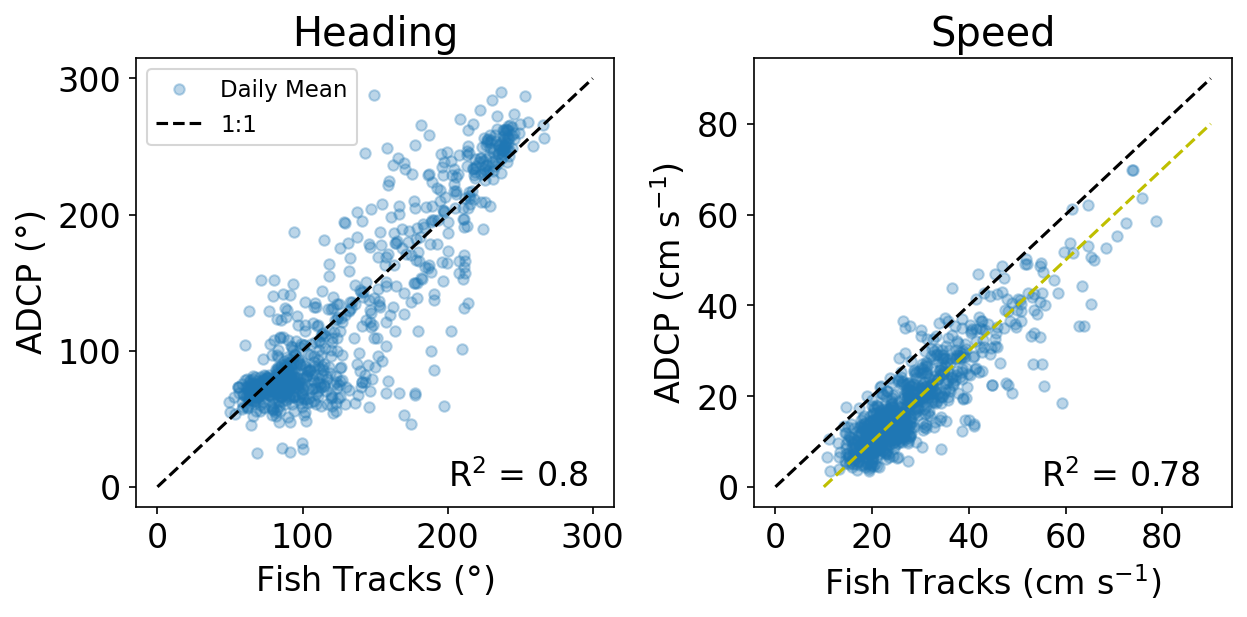

In [101]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.2,4),dpi=150)
ax1.plot(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir,'.',markersize=10,alpha=.3)
ax1.plot([0,300],[0,300],'--k')
ax1.set_ylabel('ADCP ($\degree$)')
ax1.set_xlabel('Fish Tracks ($\degree$)')
ax1.text(200,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
ax1.set_title('Heading')
ax1.legend(['Daily Mean','1:1'],fontsize=11)

ax2.plot(dfMerge.resample('1D').mean().linearSpeed*100,dfMerge.resample('1D').mean().currentSpeed,'.',markersize=10,alpha=.3)
ax2.plot([0,90],[0,90],'--k')
ax2.plot([10,90],[0,80],'--y')
ax2.set_title('Speed')
ax2.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax2.set_ylabel('ADCP (cm s$^{-1}$)')
ax2.set_xticks([0,20,40,60,80])
ax2.text(55,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearSpeed*100,dfMerge.resample('1D').mean().currentSpeed)[0][1]**2,2)))

Text(-35, 40, 'R$^{2}$ = 0.73')

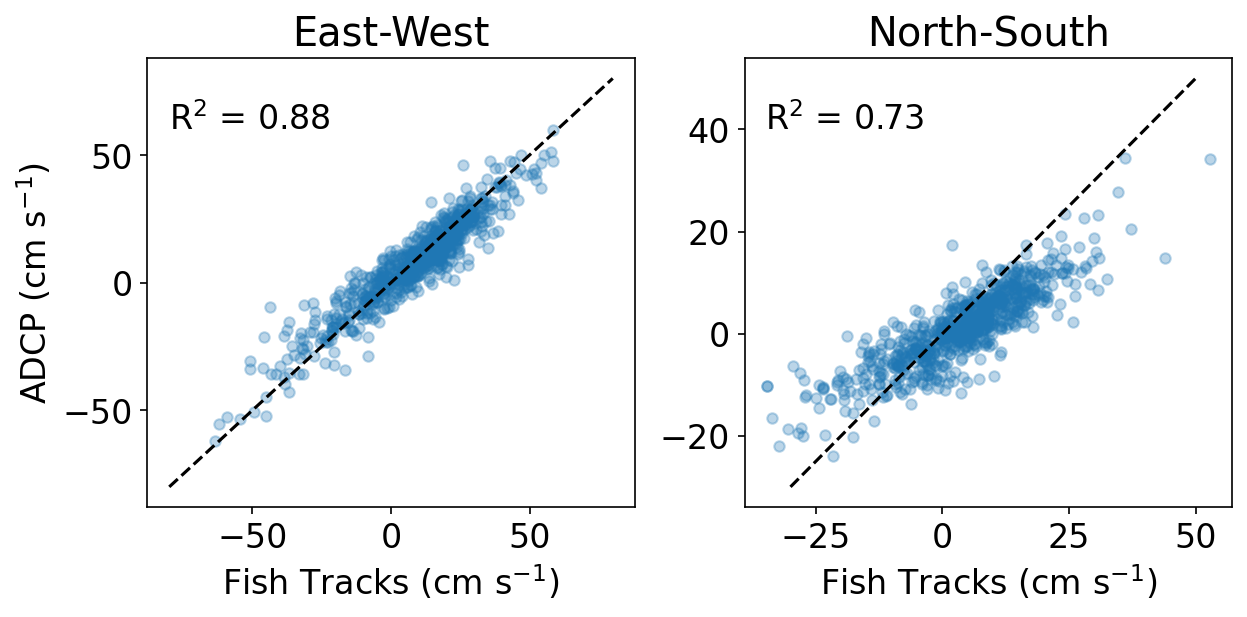

In [174]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.2,4),dpi=150)
ax1.plot(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u,'.',markersize=10,alpha=.3)
ax1.plot([-80,80],[-80,80],'--k')
ax1.set_title('East-West')
ax1.set_ylabel('ADCP (cm s$^{-1}$)')
ax1.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax1.text(-80,60, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u)[0][1]**2,2)))

ax2.plot(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v,'.',markersize=10,alpha=.3)
ax2.plot([-30,50],[-30,50],'--k')
ax2.set_title('North-South')
ax2.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax2.text(-35,40, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v)[0][1]**2,2)))

Text(-20, 25, 'R$^{2}$ = 0.79')

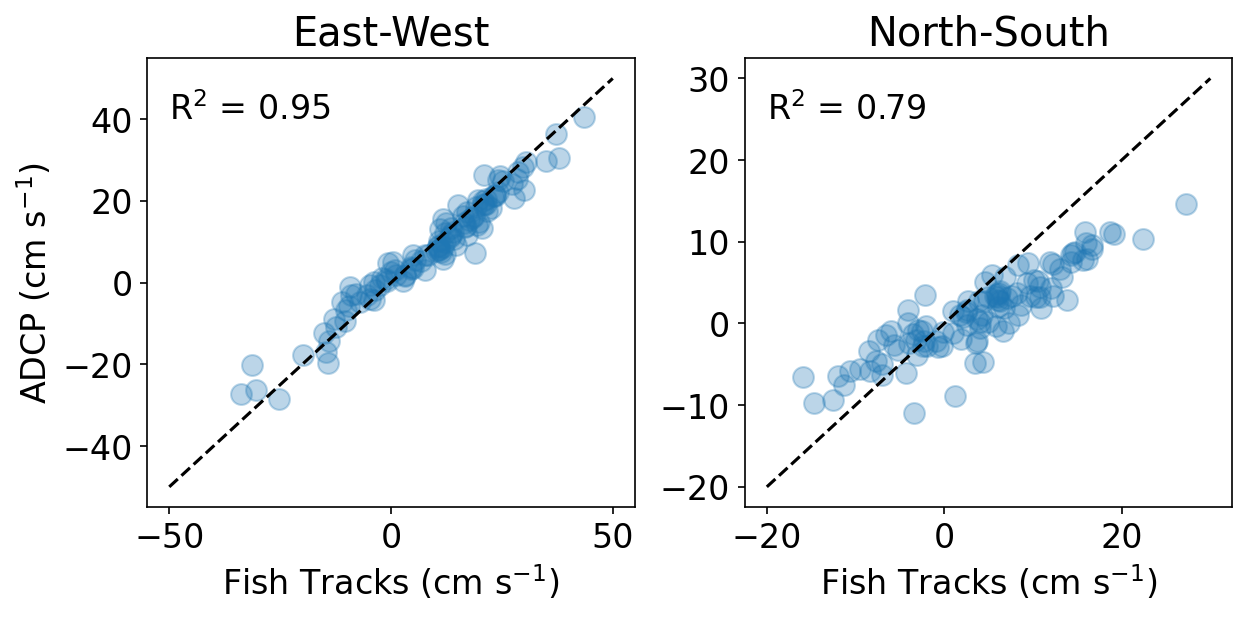

In [172]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.2,4),dpi = 150)
ax1.plot(dfMerge.resample('7D').mean().u_track,dfMerge.resample('7D').mean().u,'.',markersize=20,alpha=.3)
ax1.plot([-50,50],[-50,50],'--k')
ax1.set_title('East-West')
ax1.set_ylabel('ADCP (cm s$^{-1}$)')
ax1.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax1.text(-50,40, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('7D').mean().u_track,dfMerge.resample('7D').mean().u)[0][1]**2,2)))

ax2.plot(dfMerge.resample('7D').mean().v_track,dfMerge.resample('7D').mean().v,'.',markersize=20,alpha=.3)
ax2.plot([-20,30],[-20,30],'--k')
ax2.set_title('North-South')
ax2.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax2.text(-20,25, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('7D').mean().v_track,dfMerge.resample('7D').mean().v)[0][1]**2,2)))

array([-56.51915125, -52.006762  , -48.2710265 ])

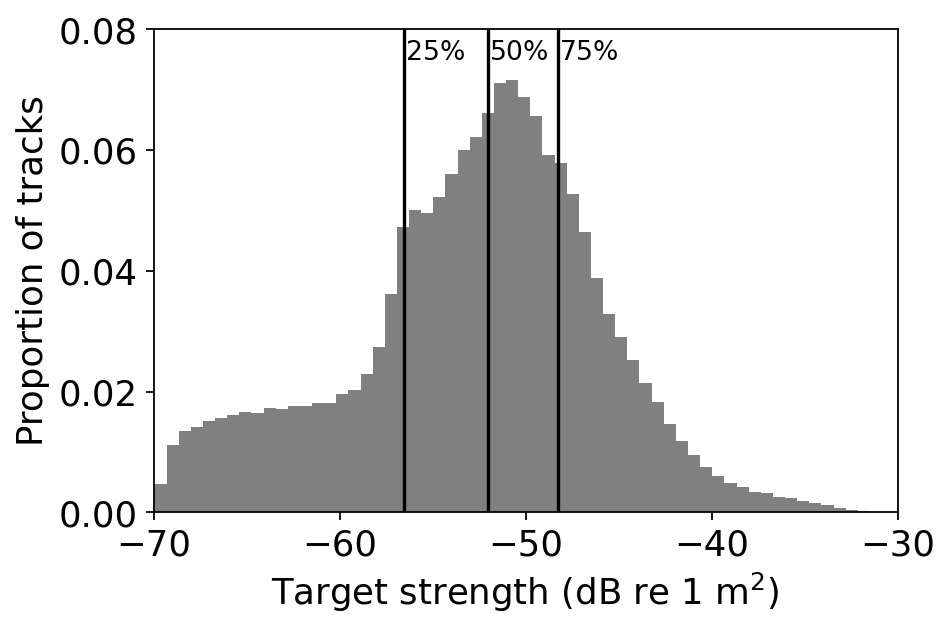

In [98]:
fig = plt.figure(dpi=160)
plt.hist(dfMerge.TS_mean,bins=60,density=True,color='grey');
plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
plt.axis([-70,-30,0,.08])
plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Target strength (dB re 1 m$^{2}$)')
plt.ylabel('Proportion of tracks')
dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values

Text(0.5, 0, 'Date')

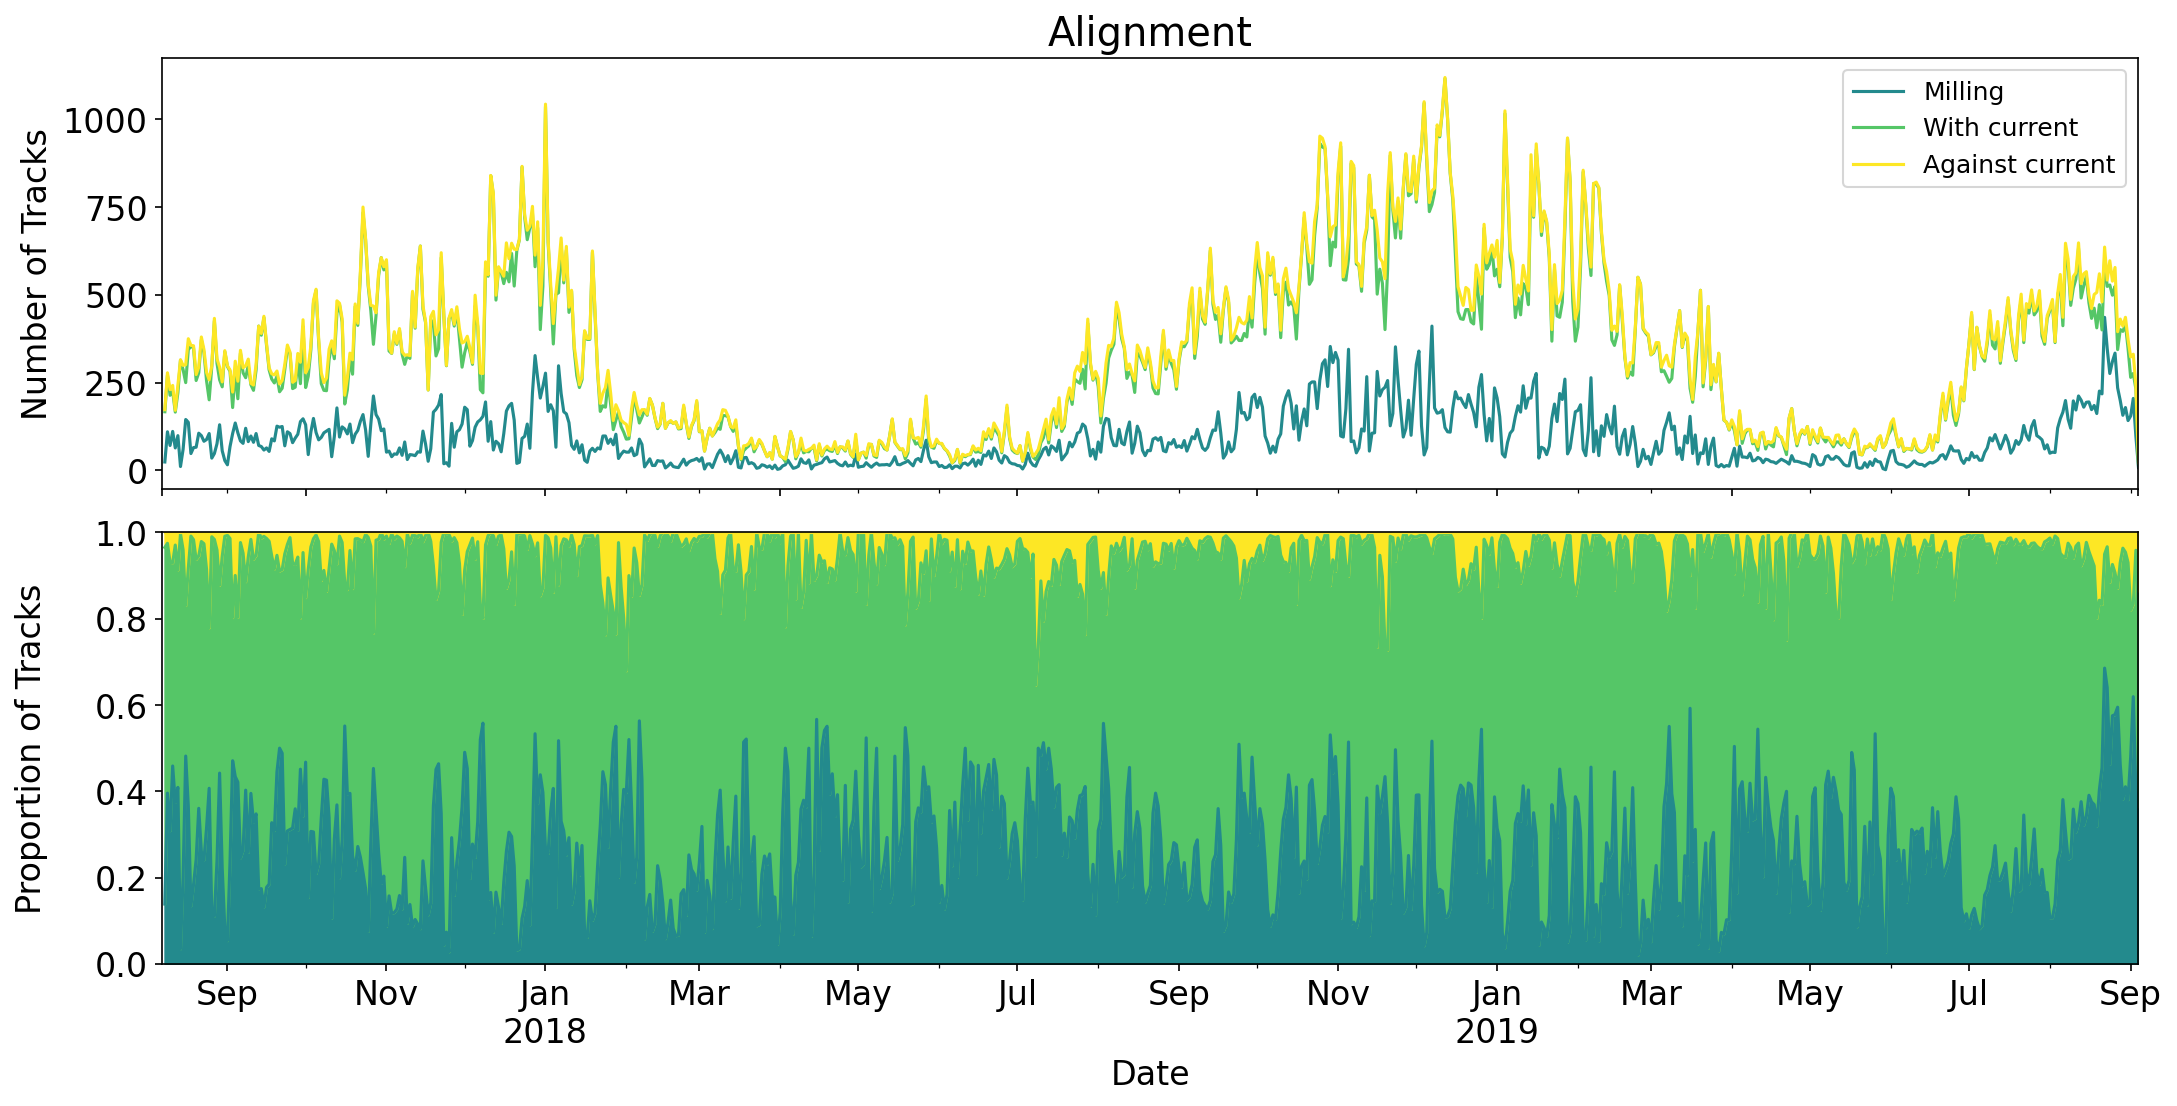

In [92]:
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
resample = '1D'
# WithCur: 0 = milling, 1 = with current, 2 = against current
fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.withCur== 0].resample(resample).count().speed.plot(color=colors[1]) # Milling
dfMerge[(dfMerge.withCur== 0)|(dfMerge.withCur== 1)].resample(resample).count().withCur.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().withCur.plot(color=colors[3])

ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['Milling','With current','Against current'],fontsize=12)
plt.title('Alignment')
plt.ylabel('Number of Tracks')


ax2 = plt.subplot(212)
hold = 0
ct = 1
for k in [0,1,2]:
    dfCur = dfMerge[dfMerge.withCur==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.withCur/dfCurTot.withCur)
    ax2.plot(d+hold,color = colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color = colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

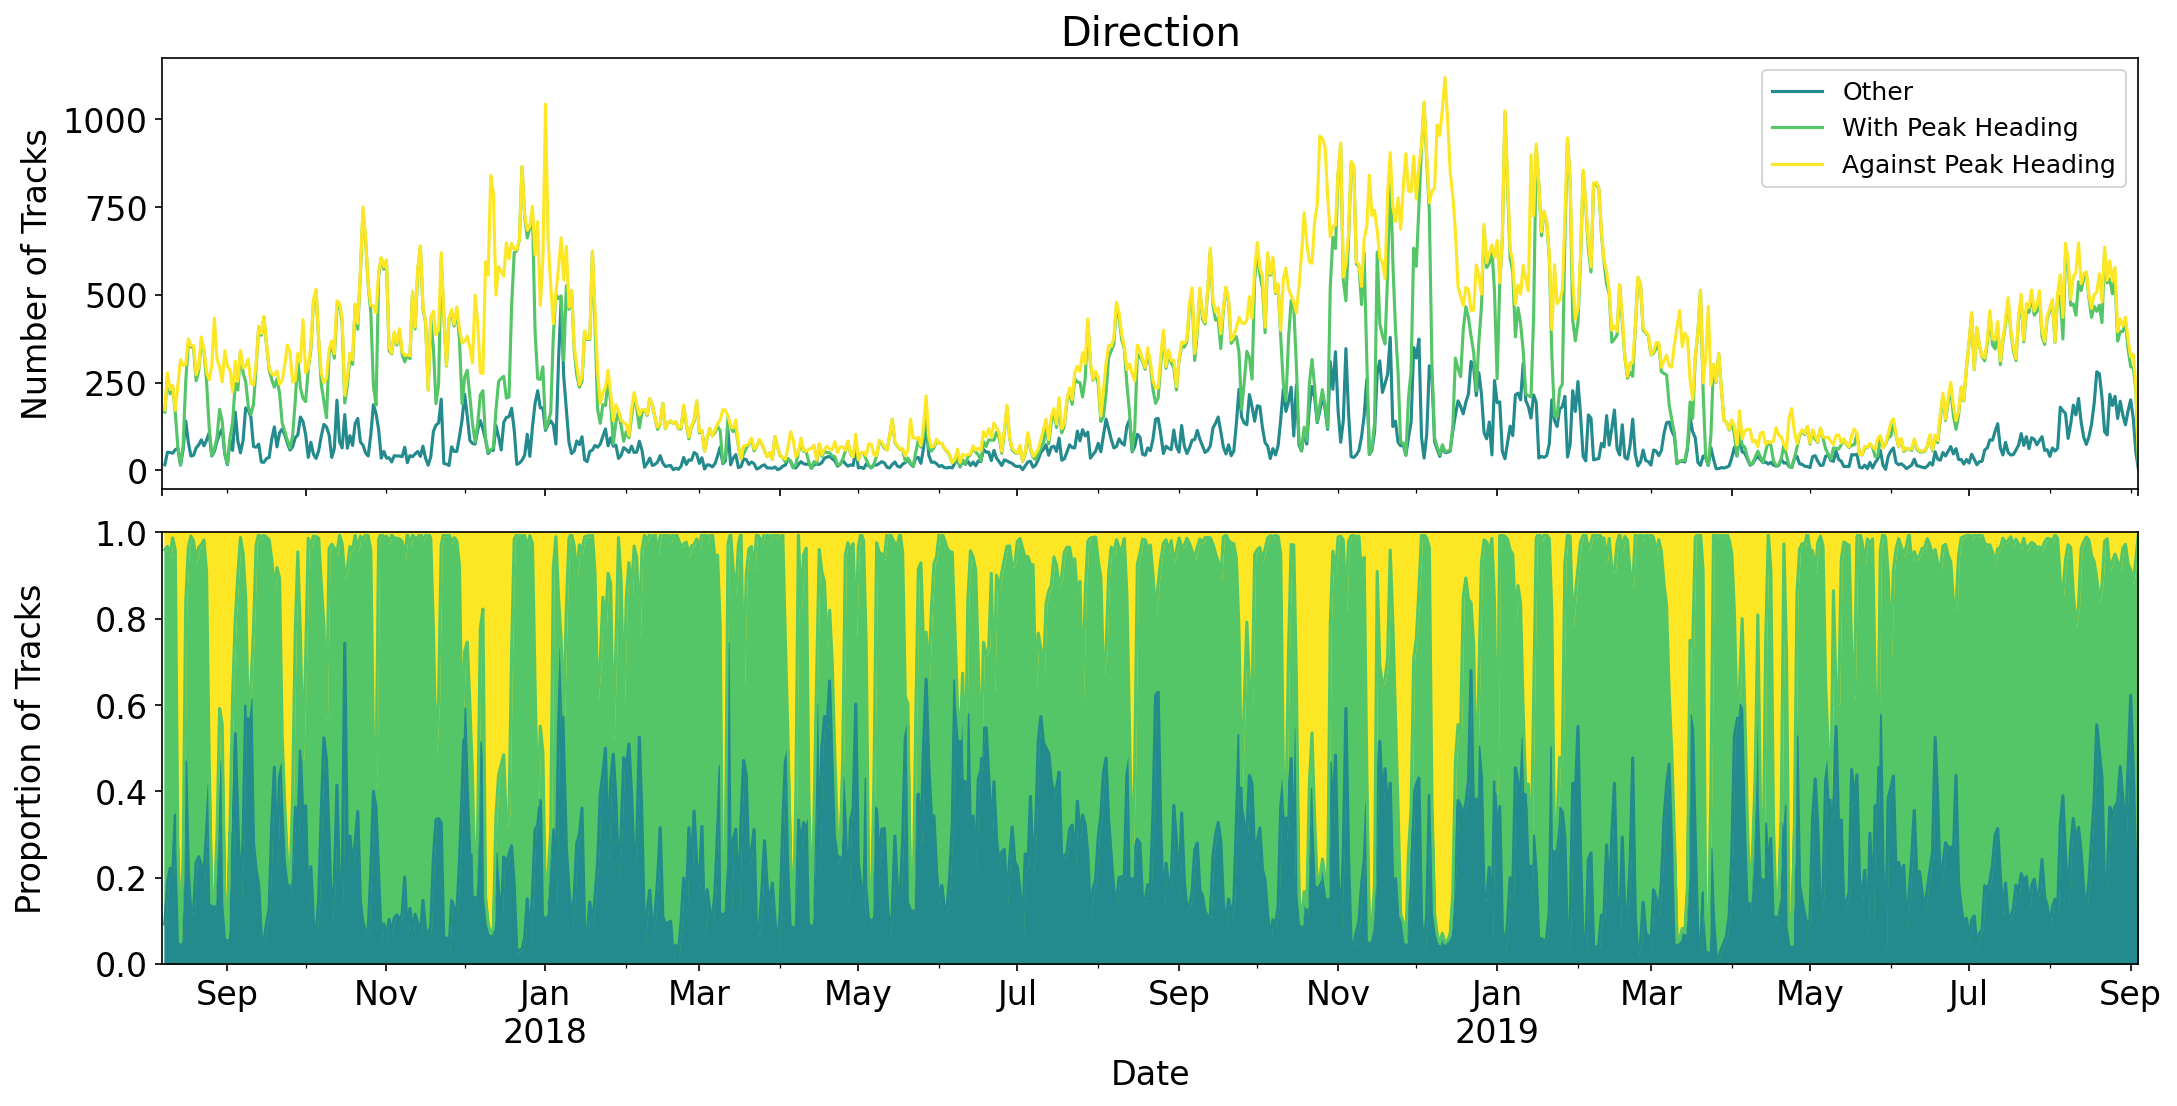

In [99]:
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
resample = '1D'

dfMergeCur = dfMerge#[(dfMerge.tsZone==3)]#|(dfMerge.tsZone==1)]

# WithCur: 0 = milling, 1 = with current, 2 = against current
fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMergeCur[dfMergeCur.withPrimary== 0].resample(resample).count().speed.plot(color=colors[1]) # Milling
dfMergeCur[(dfMergeCur.withPrimary== 0)|(dfMergeCur.withPrimary== 1)].resample(resample).count().withPrimary.plot(color=colors[2]) # milling and with current
dfMergeCur.resample(resample).count().withPrimary.plot(color=colors[3])

ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['Other','With Peak Heading','Against Peak Heading'],fontsize=12)
plt.title('Direction')
plt.ylabel('Number of Tracks')

ax2 = plt.subplot(212)
hold = 0

ct = 1
for k in [0,1,2]:
    dfCur = dfMergeCur[dfMergeCur.withPrimary==k].resample(resample).count()
    dfCurTot = dfMergeCur.resample(resample).count()
    d = (dfCur.withPrimary/dfCurTot.withPrimary)
    ax2.plot(d+hold,color = colors[ct])
    a = d+hold
    b = 0+hold
    try:
        ax2.fill_between(dfCur.index,a[:len(dfCur.index)],b[:len(dfCur.index)],color = colors[ct])
    except:
        ax2.fill_between(dfCur.index,a[:len(dfCur.index)],b,color = colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])


ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

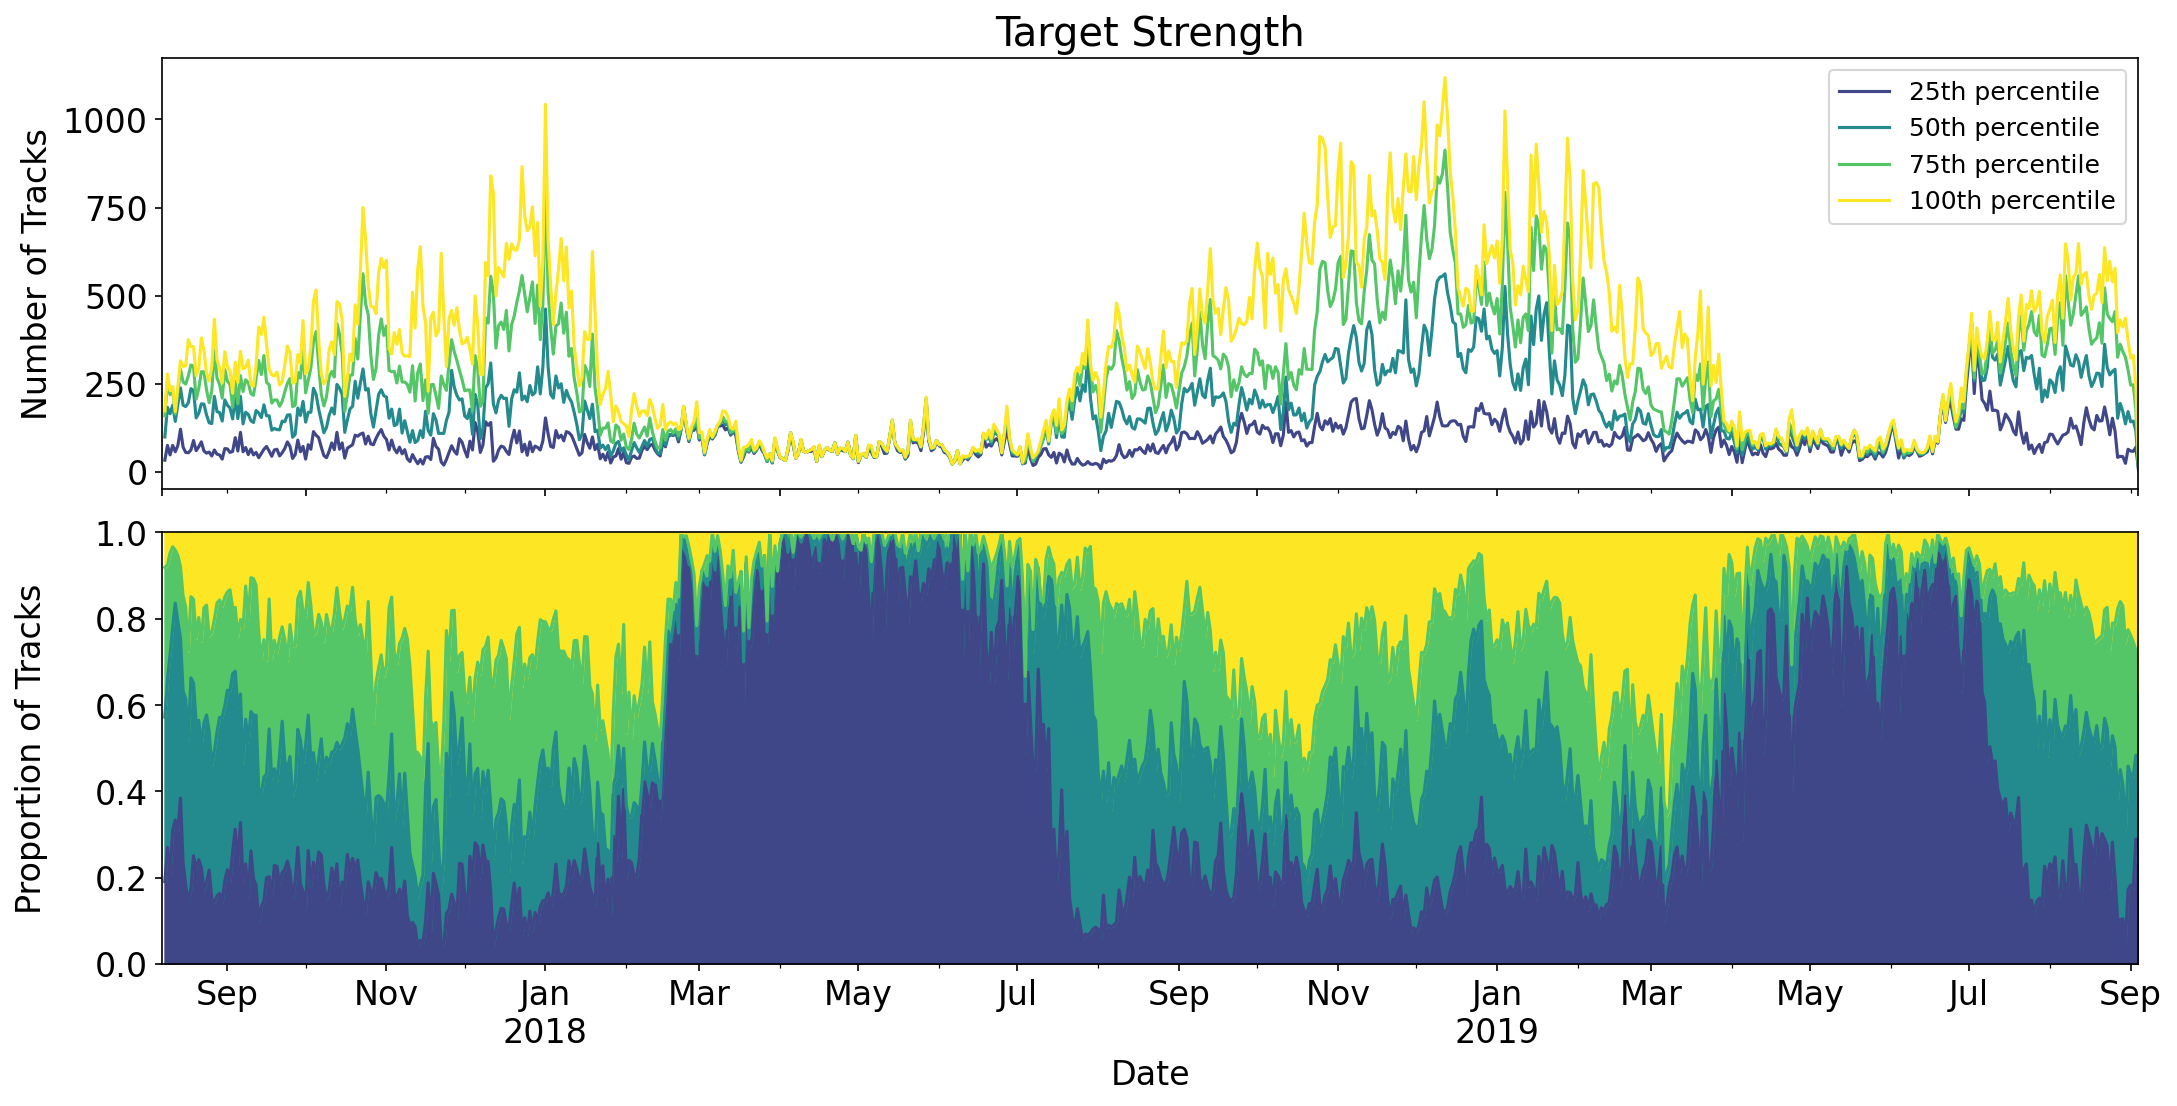

In [95]:
resample = '1D'
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
# tsZone: 0 = 0-25%, 1 = 25-50%, 2 = 50-75%, 3 = 75-100%

fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.tsZone== 0].resample(resample).count().speed.plot(color=colors[0]) # Milling
dfMerge[(dfMerge.tsZone== 0)|(dfMerge.tsZone== 1)].resample(resample).count().tsZone.plot(color=colors[1]) # milling and with current
dfMerge[(dfMerge.tsZone== 0)|(dfMerge.tsZone== 1)|(dfMerge.tsZone== 2)].resample(resample).count().tsZone.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().speed.plot(color=colors[3])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['25th percentile','50th percentile','75th percentile','100th percentile'],fontsize=12)
plt.title('Target Strength')
plt.ylabel('Number of Tracks')

ax2 = plt.subplot(212)
hold = 0
ct = 0
for k in [0,1,2,3]:
    dfCur = dfMerge[dfMerge.tsZone==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.tsZone/dfCurTot.tsZone)
    ax2.plot(d+hold,color=colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color=colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

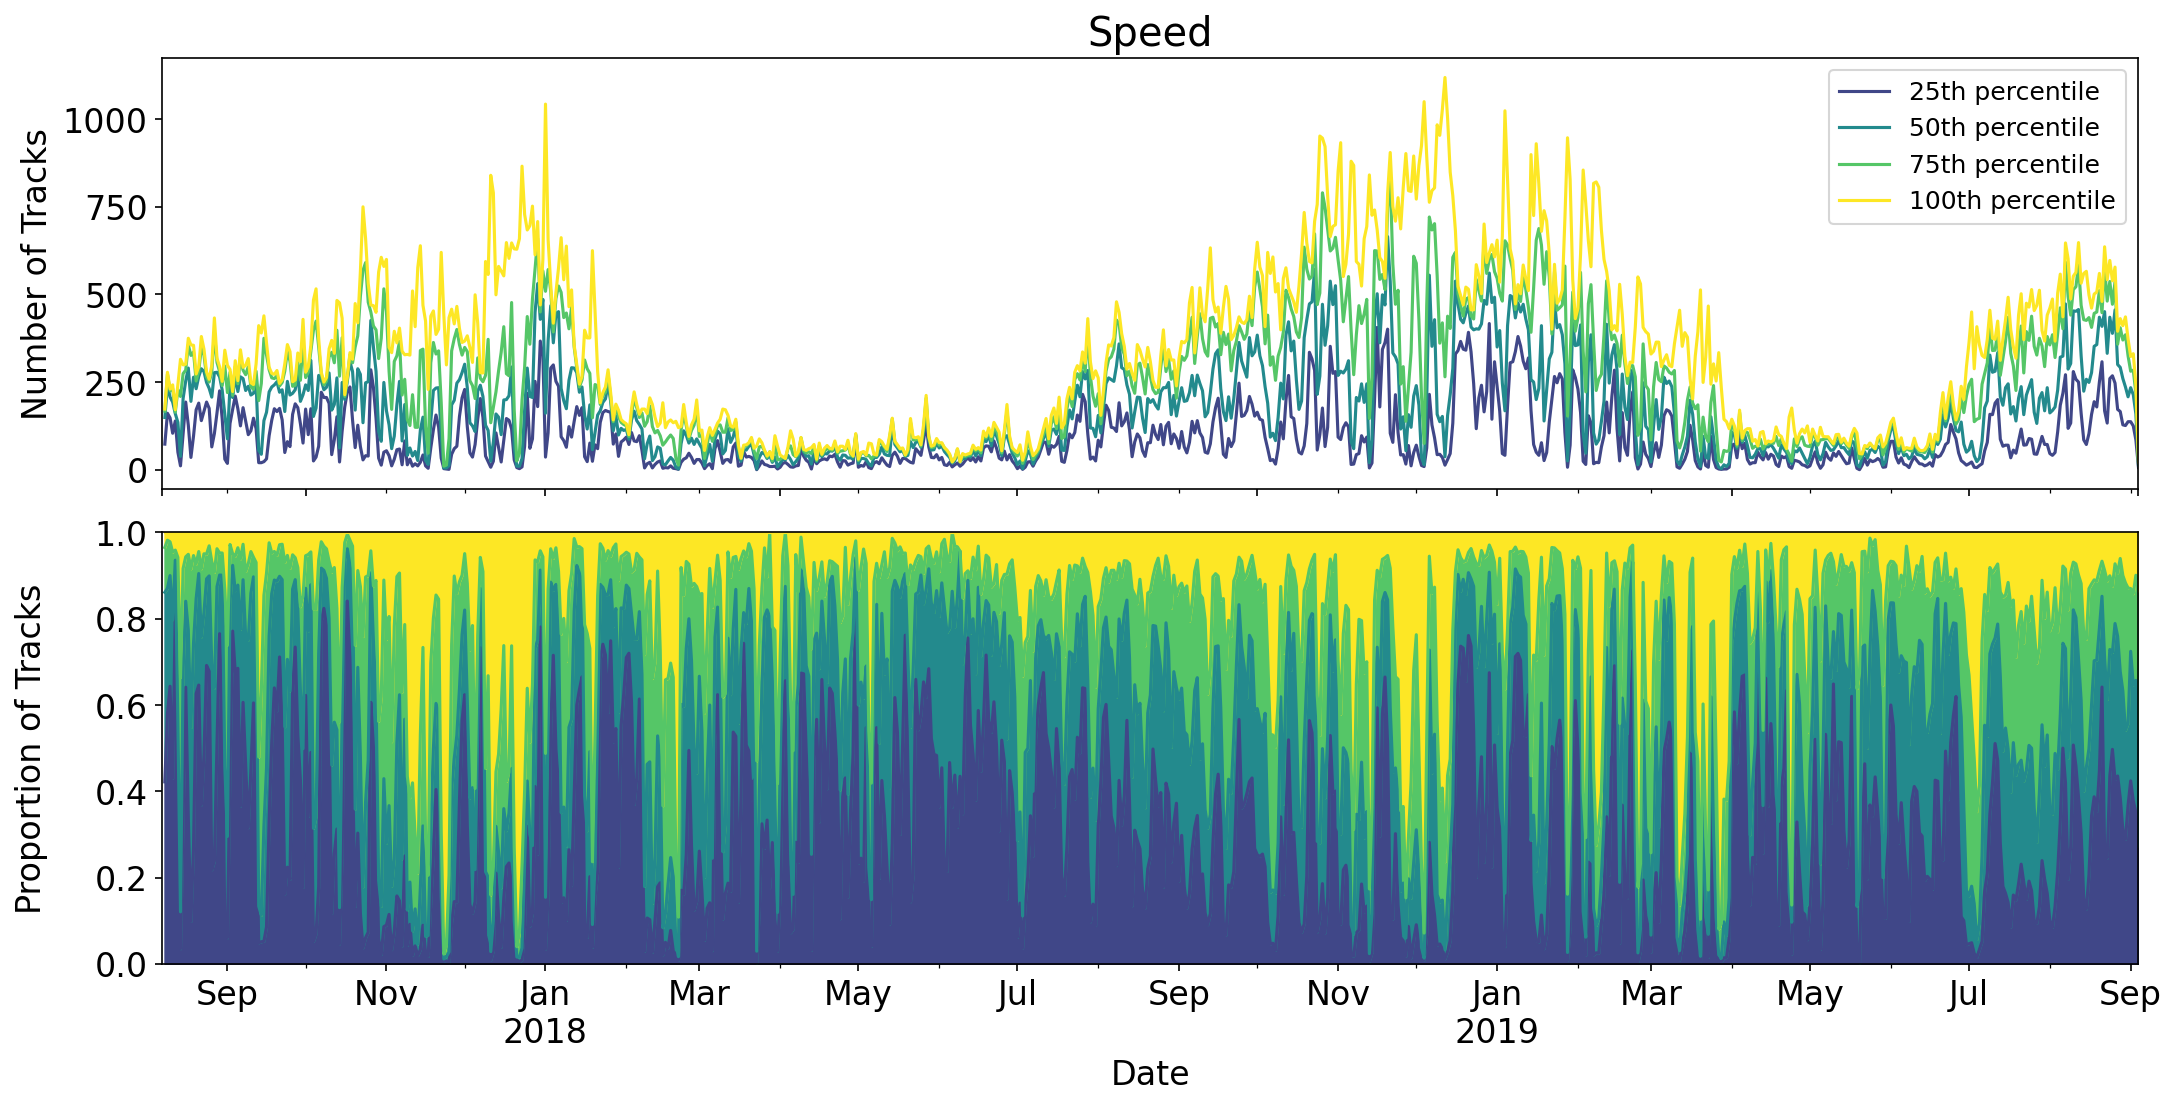

In [96]:
resample = '1D'

# tsZone: 0 = 0-25%, 1 = 25-50%, 2 = 50-75%, 3 = 75-100%

fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.speed== 0].resample(resample).count().speed.plot(color=colors[0]) # Milling
dfMerge[(dfMerge.speed== 0)|(dfMerge.speed== 1)].resample(resample).count().tsZone.plot(color=colors[1]) # milling and with current
dfMerge[(dfMerge.speed== 0)|(dfMerge.speed== 1)|(dfMerge.speed== 2)].resample(resample).count().tsZone.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().speed.plot(color=colors[3])
plt.legend(['25th percentile','50th percentile','75th percentile','100th percentile'],fontsize=12)
plt.title('Speed')
plt.ylabel('Number of Tracks')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])


ax2 = plt.subplot(212)
hold = 0
ct =0
for k in [0,1,2,3]:
    dfCur = dfMerge[dfMerge.speed==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.speed/dfCurTot.speed)
    ax2.plot(d+hold,color=colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color=colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

27.511073

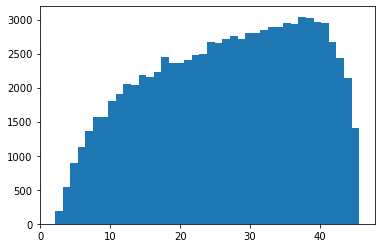

In [41]:
plt.hist(a.Target_depth_mean,bins=40)
a.Target_depth_mean.median()

26.7163365

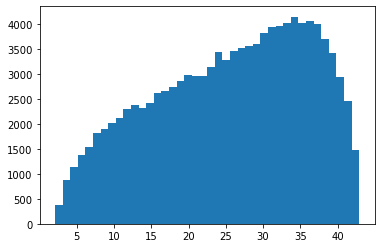

In [42]:
plt.hist(b.Target_depth_mean,bins=40)
b.Target_depth_mean.median()

28.016197

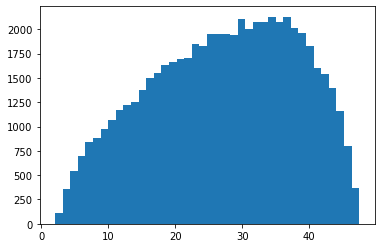

In [43]:
plt.hist(c.Target_depth_mean,bins=40)
c.Target_depth_mean.median()

array([[1.       , 0.9437543],
       [0.9437543, 1.       ]])

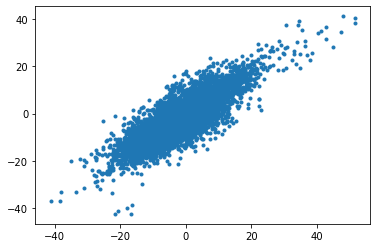

In [38]:
import matplotlib.pyplot as plt
plt.plot(np.ravel(bigDs[0].sel(depth=20).v_1206.values),np.ravel(bigDs[0].sel(depth=28).v_1206.values),'.')
np.corrcoef(np.ravel(bigDs[0].sel(depth=32).v_1206.values),np.ravel(bigDs[0].sel(depth=28).v_1206.values))